<a href="https://colab.research.google.com/github/raultyv/Machine_learning/blob/main/GXBoost_P1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
###############################################################################
#### Proyecto 1: Machine learning  ############################################
#### Paper: Comparison of machine learning algorithm for Santander dataset  ###
###############################################################################
#### Integrantes  #############################################################
#### -
#### -
#### -
#### -
###############################################################################

## Paso 1: Importar los dateset enviados por el profesor
import pandas as pd
import numpy as np

# 1.1 Definir las rutas (al estar en la raíz de la carpeta 'Files', la ruta es directa)
train_path = '/content/train.csv'
test_path = '/content/test.csv'

# 1.2 Cargar los datos
# El paper menciona que trabajamos con 200,000 registros por archivo
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

train_df.head()
test_df.head()

print(f"¡Carga completada desde el almacenamiento local!")
print(f"Registros cargados: {len(train_df)}")

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Paso 2: Pre - procesamiento de la información
# 2.1 Separación de variables predictoras (X) y objetivo (y)
# Basado en la estructura vista en head(), eliminamos ID y Target
X = train_df.drop(['ID_code', 'target'], axis=1)
y = train_df['target']



¡Carga completada desde el almacenamiento local!
Registros cargados: 200000


Iniciando entrenamiento de XGBoost con Scale Factor de 8.95...
[0]	validation_0-auc:0.58804
[100]	validation_0-auc:0.80433
[200]	validation_0-auc:0.83751
[300]	validation_0-auc:0.85425
[400]	validation_0-auc:0.86416
[500]	validation_0-auc:0.87101
[600]	validation_0-auc:0.87627
[700]	validation_0-auc:0.88008
[800]	validation_0-auc:0.88297
[900]	validation_0-auc:0.88519
[999]	validation_0-auc:0.88712

--- REPORTE FINAL DE MÉTRICAS: XGBOOST ---
              precision    recall  f1-score   support

           0       0.97      0.85      0.91     35980
           1       0.36      0.75      0.49      4020

    accuracy                           0.84     40000
   macro avg       0.67      0.80      0.70     40000
weighted avg       0.91      0.84      0.87     40000

AUC-ROC Final: 0.8872
F1-Score (Clase 1): 0.4906


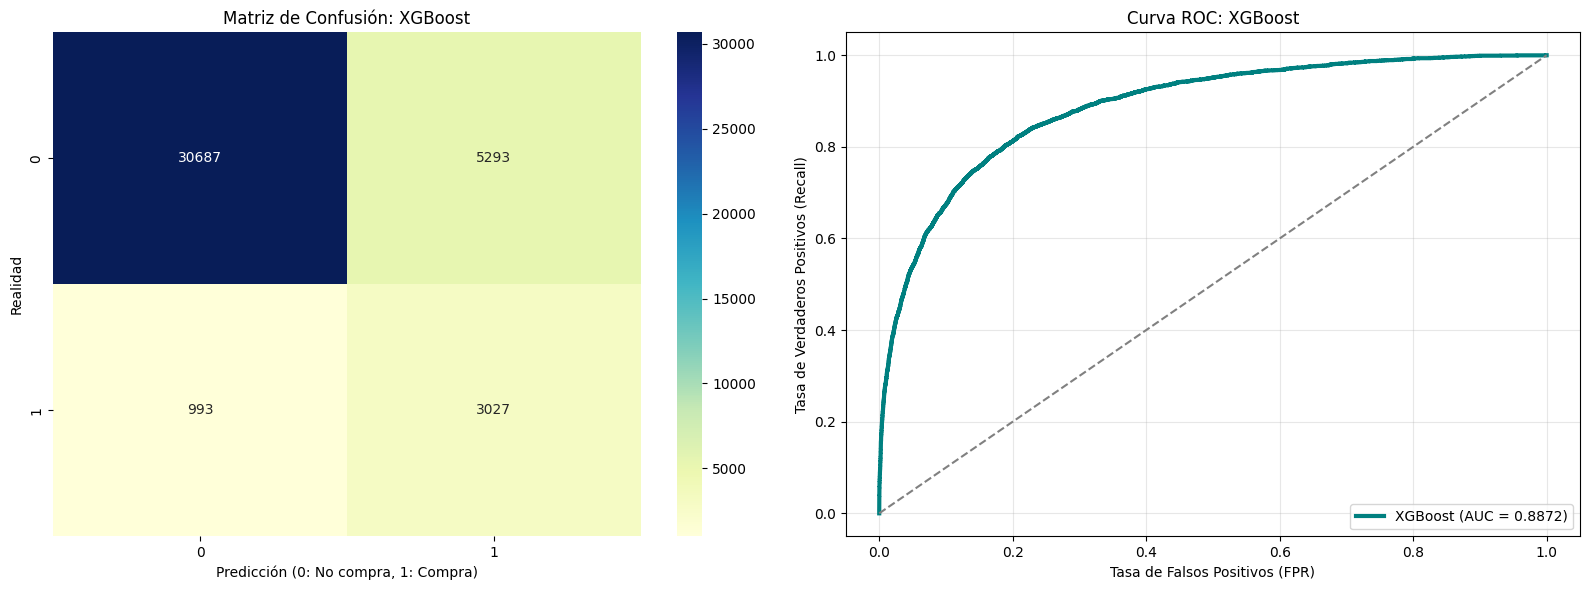

In [9]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# 3.1 División de datos con estratificación (mantiene la proporción de la clase 1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3.2 Cálculo del factor de balanceo (Scale Factor)
scale_factor = (y_train == 0).sum() / (y_train == 1).sum()

# 3.3 Configuración de XGBoost (API v2.x)
model_xgb = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=3,
    scale_pos_weight=scale_factor,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    eval_metric='auc',
    early_stopping_rounds=100
)

# 3.4 Entrenamiento
print(f"Iniciando entrenamiento de XGBoost con Scale Factor de {scale_factor:.2f}...")
model_xgb.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

# 3.5 Predicciones de clase (0/1) y Probabilidades (para el AUC)
y_pred_xgb = model_xgb.predict(X_val)
y_proba_xgb = model_xgb.predict_proba(X_val)[:, 1]

# 3.6 Cálculo de métricas comparativas
auc_final = roc_auc_score(y_val, y_proba_xgb)
f1_final = f1_score(y_val, y_pred_xgb)

print("\n" + "="*50)
print("--- REPORTE FINAL DE MÉTRICAS: XGBOOST ---")
print(classification_report(y_val, y_pred_xgb))
print(f"AUC-ROC Final: {auc_final:.4f}")
print(f"F1-Score (Clase 1): {f1_final:.4f}")
print("="*50)

# 3.7 Visualización Profesional
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# A. Matriz de Confusión (Interpretación de aciertos y errores)
sns.heatmap(confusion_matrix(y_val, y_pred_xgb), annot=True, fmt='d', cmap='YlGnBu', ax=ax[0])
ax[0].set_title('Matriz de Confusión: XGBoost')
ax[0].set_xlabel('Predicción (0: No compra, 1: Compra)')
ax[0].set_ylabel('Realidad')

# B. Curva ROC (Capacidad de discriminación)
fpr, tpr, _ = roc_curve(y_val, y_proba_xgb)
ax[1].plot(fpr, tpr, color='teal', lw=3, label=f'XGBoost (AUC = {auc_final:.4f})')
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[1].set_title('Curva ROC: XGBoost')
ax[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
ax[1].set_ylabel('Tasa de Verdaderos Positivos (Recall)')
ax[1].legend(loc="lower right")
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

/tmp/ipython-input-369012429.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia (Gain)', y='Variable', data=importances_df.head(15), palette='viridis')


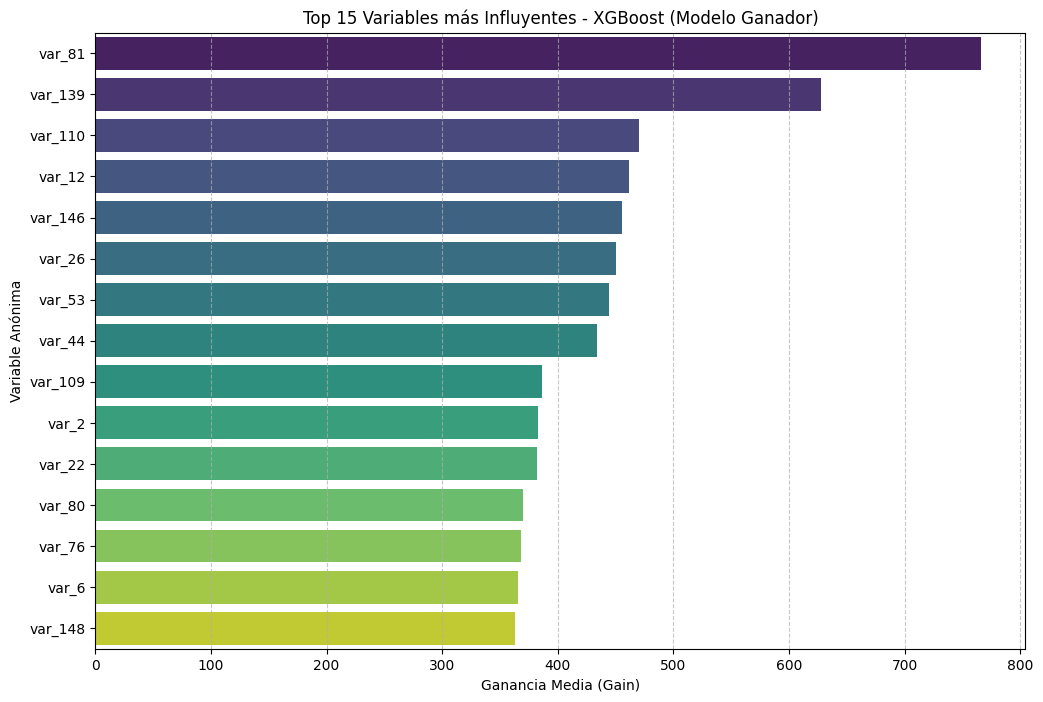

Total de variables que aportan valor al modelo: 198


In [10]:
# 6.1 Extraer la importancia de las variables
# Usamos 'gain' porque mide la contribución de cada variable a la mejora del modelo
importances = model_xgb.get_booster().get_score(importance_type='gain')
importances_df = pd.DataFrame({
    'Variable': importances.keys(),
    'Importancia (Gain)': importances.values()
}).sort_values(by='Importancia (Gain)', ascending=False)

# 6.2 Visualizar las 15 variables más influyentes
plt.figure(figsize=(12, 8))
sns.barplot(x='Importancia (Gain)', y='Variable', data=importances_df.head(15), palette='viridis')
plt.title('Top 15 Variables más Influyentes - XGBoost (Modelo Ganador)')
plt.xlabel('Ganancia Media (Gain)')
plt.ylabel('Variable Anónima')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

print(f"Total de variables que aportan valor al modelo: {len(importances)}")